# Differential equation (Langevin equation)

This function g models the effect of the equation:
$$\frac{\partial \sigma_i}{\partial t}  = -\frac{\partial V}{\partial \sigma_i} +
\sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t)$$

with $V = \lambda (\sigma_i^2 - 1)^2$ so that $\frac{\partial V}{\partial\sigma_i} = 4\lambda(\sigma_i^2 - 1)\sigma_i$. This term is added to ensure that $\sigma_i$ decays exponentially to either $\pm 1$ within a time $\tau \sim \frac{1}{\lambda}$

The $\xi_i(t)$ term represents Gaussian White Noise

$$ \langle \xi_i(t) \xi_j(t') \rangle = 2T\delta_{ij}\delta(t-t')$$
i.e., $\xi_i(t)$ follows a $N(0, 2T)$, there is no correlation between the noise of different spins  ($i \neq j$) and the process is Markovian and therefore has no memory (the correlation is only nonzero when $t = t'$)

# Finite differences

Now we have to translate this differential equation into some finite difference equation. Since the neural network works with integer time increments, the exponential decay dynamics must be fast in times of order 1 and the Ising dynamics must be "slow"

$$\sigma_i(t+1) - \sigma_i(t) = -4\lambda(\sigma_i^2 - 1)\sigma_i + \epsilon\left( \sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t) \right)$$

absorbing 4 into $\lambda$ and clearing \sigma_i(t+1):

$$g (\sigma_i(t)) = \sigma_i(t+1)= -\lambda(\sigma_i^2 - 1)\sigma_i + \epsilon\left( \sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t) \right) + \sigma_i(t)$$

This will be our dynamical function $g (\sigma_i(t))$ defined later in the code

# Values of the dynamical parameters

<!-- (The values of the parameters are very important for the model to converge suscessfully.Too big parameter values (close or bigger than one) will cause the network to oscilate wildly trying to overcompensate the errors, while small values will converge very slowly but safely. There are another also other effects when varying $\epsilon$ and $\lambda$.)

Normally we want $\lambda > \epsilon$ (i.e., the network decays to $\pm 1$ faster than the Ising dynamics) and also $\lambda + \epsilon \lesssim 1$ -->

Now with the new normalization $\sigma_i(t+1) = \frac{\sigma_i(t+1)}{\langle \sigma_i(t+1) \rangle}$ all spins are normalized to $\pm 1$ 

(TODO: is this in some way equivalent to define the time evolution operator to be unitary? Are there better normalizations?)

In [1]:
import numpy as np
# define functions and parameters T, lamb, eps
T = 0.0
lamb = 0.0 # better with lambda = 0
eps = 1.0
def g(state_t0, weights):
    h = np.dot(weights, state_t0)
    xi = np.sqrt(2*T)*np.random.randn(np.size(state_t0))
    state_t1 = -lamb*(state_t0**2 - 1)*state_t0 + eps*(h + xi) + state_t0
    return state_t1/np.mean(np.abs(state_t1))

$$J_{ij} = \frac{1}{N}\sum_{\lambda=1}^K m_i^{(\lambda)} m_j^{(\lambda)}$$

$m_i^{(\lambda)}$ can be written as a slice of a [Hadamard matrix](https://en.wikipedia.org/wiki/Hadamard_matrix), since the patterns have to be orthogonal, $\sum_i m_i^{(\lambda)} m_i^{(\lambda')} = 0 $ if $\lambda \neq \lambda'$
$i = 1..N$ and $\lambda = 1..K$. $N = L^2$ is the size of the newtork and $K$ is the number of stationary states of the system (memory patterns)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
from scipy.linalg import hadamard


## Parameters
L = 10 # size of the newtork
N = L**2
K = 1 # number of stationary states of the system (memory patterns)
lamb = 0.0
eps = 1.0
T = 0.0 # Temperature
nsteps = 10 # number of steps of the simulation

def iterate_plot(nsteps):

    had_size = 2**np.ceil(np.log2(N))
    # had_size has to be a power of two
    H = np.squeeze(hadamard(had_size)) # Orthogonal patterns
    
    if K == 1:
        H = H[0:N, L:L+1] 
    else:
        H = H[0:N, 0:K]

#     H = H[0:N, 10:11]

    # create an instance of the class HopfieldNetwork
    hopfield_net = network.HopfieldNetwork(nr_neurons=N)
    # instantiate a pattern factory
    factory = pattern_tools.PatternFactory(L, L)

    # einstein summation convention, sum in lambda index
    hopfield_net.weights = 1/N*np.einsum('ik,jk->ij', H, H)

    # set user defined function to update the state
    hopfield_net.set_dynamics_to_user_function(g)
    # hopfield_net.set_dynamics_sign_sync()

    stationary = np.squeeze(H) # this should be an stationary state

    # comment the next line to start from a random state
    # hopfield_net.state = pattern_tools.flip_n(stationary, nr_of_flips=20) # flip some spins from the stat state

    states = hopfield_net.run_with_monitoring(nr_steps=nsteps)

    # each network state is a vector. reshape it to the same shape used to create the patterns.
    states_as_patterns = factory.reshape_patterns(states[0:nsteps:round(nsteps/10)])
    # plot the states of the network (10 equispaced states)
    old = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (20, 20) # Bigger size
    plot_tools.plot_pattern_list(states_as_patterns)
    plt.rcParams["figure.figsize"] = old

    # plot final state and to compare it against the stationary state
    plot_tools.plot_pattern(np.reshape(states[-1], (L, L)))
    print('Final state')

    if len(np.shape(np.squeeze(H))) < 2:
        plot_tools.plot_pattern(np.reshape(H, (L, L)))
        print('Stationary state')

    else:

        H_patterns = factory.reshape_patterns(H.T)
        print(np.shape(H.T))
        old = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (20, 20) # Bigger size
        plot_tools.plot_pattern_list(H_patterns)
        plt.rcParams["figure.figsize"] = old
        print('Stationary states')
    

# Iteration at $T = 0$

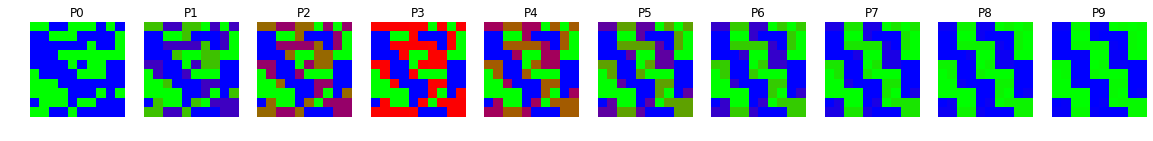

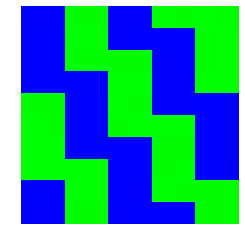

Final state


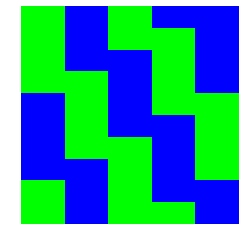

Stationary state


In [3]:
L = 10 # size of the newtork
N = L**2
K = 1
lamb = 0.0
eps = 1.0
T = 0.0 # Temperature
nsteps = 10 # number of steps of the simulation

iterate_plot(nsteps)

# Iteration at $T = 0.01 $

More temperature means more fluctuations. Note how also $\text{nsteps}$ grows with $T$

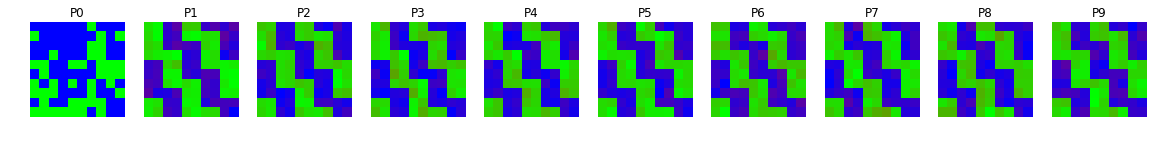

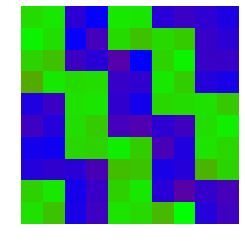

Final state


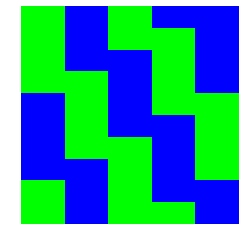

Stationary state


In [4]:
L = 10 # size of the newtork
N = L**2
K = 1 # number of stationary states of the system (memory patterns)
lamb = 0.0
eps = 1.0
T = 0.01 # Temperature
nsteps = 1000 # number of steps of the simulation

iterate_plot(nsteps)

# Iteration at $T = 0.1$

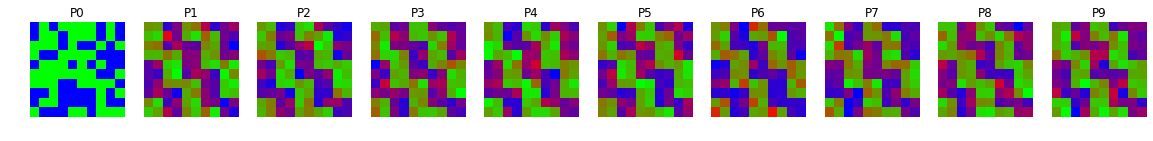

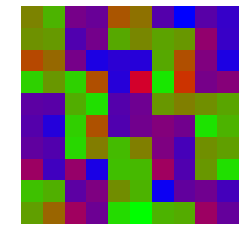

Final state


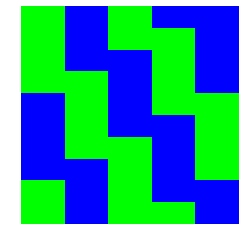

Stationary state


In [5]:
L = 10 # size of the newtork
N = L**2
K = 1 # number of stationary states of the system (memory patterns)
lamb = 0.0
eps = 1.0
T = 0.1 # Temperature
nsteps = 10000 # number of steps of the simulation

iterate_plot(nsteps)

# $T = 2.0$

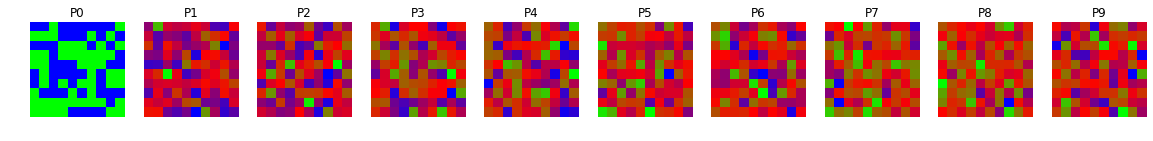

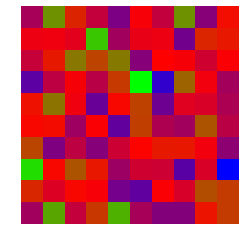

Final state


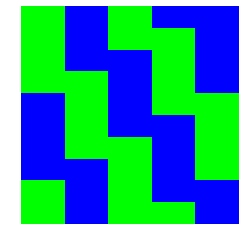

Stationary state


In [54]:
L = 10 # size of the newtork
N = L**2
K = 1 # number of stationary states of the system (memory patterns)
lamb = 0.0
eps = 1.0
T = 2.0 # Temperature
nsteps = 100 # number of steps of the simulation

iterate_plot(nsteps)

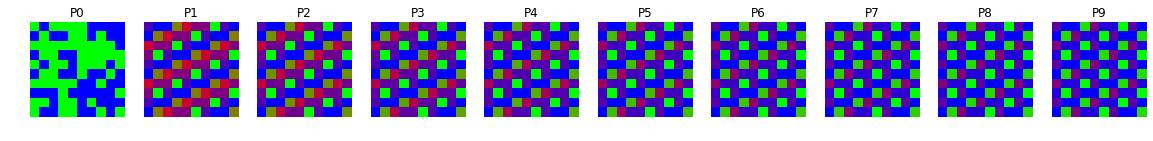

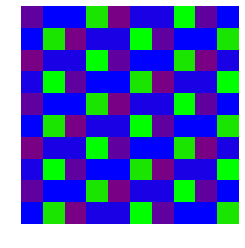

Final state
(5, 100)


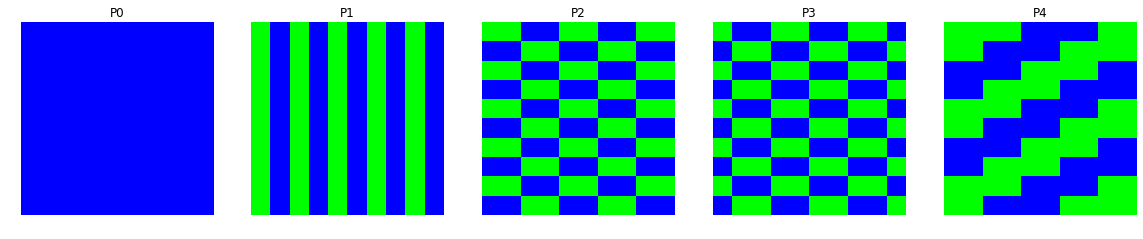

Stationary states


In [21]:
L = 10 # size of the newtork
N = L**2
K = 5 # number of stationary states of the system (memory patterns)
lamb = 0.0
eps = 1.0
T = 0.0 # Temperature
nsteps = 100 # number of steps of the simulation

iterate_plot(nsteps)

# $T= 0, K = 5$

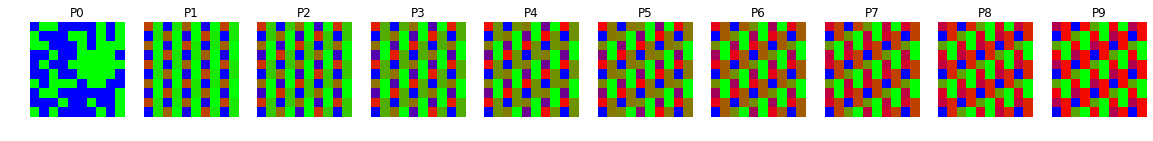

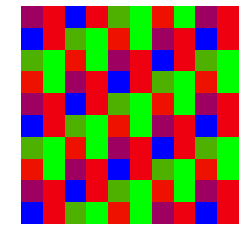

Final state
(5, 100)


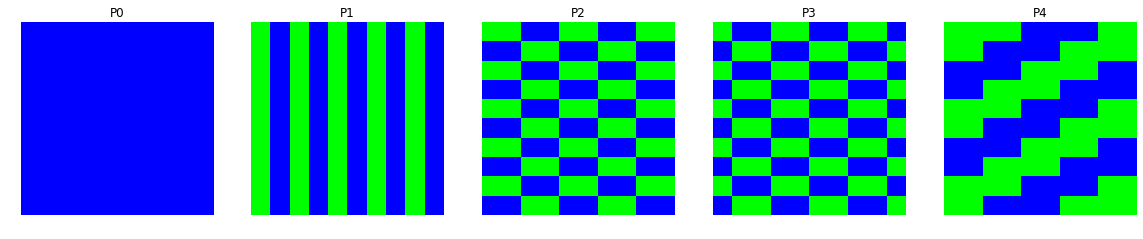

Stationary states


In [25]:
L = 10 # size of the newtork
N = L**2
K = 5 # number of stationary states of the system (memory patterns)
lamb = 0.0
eps = 1.0
T = 0.0 # Temperature
nsteps = 100 # number of steps of the simulation

iterate_plot(nsteps)

# $T = 0, K = 5, \lambda = 0.4$

Sometimes $\lambda \neq 0$ can help the network convergence. Note that metastable patterns also appear from time to time (run this cell several times)

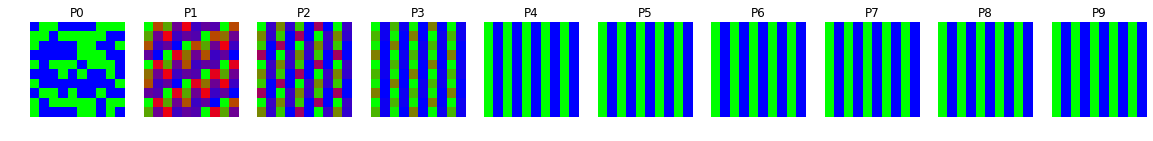

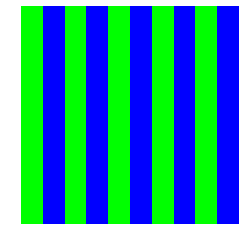

Final state
(5, 100)


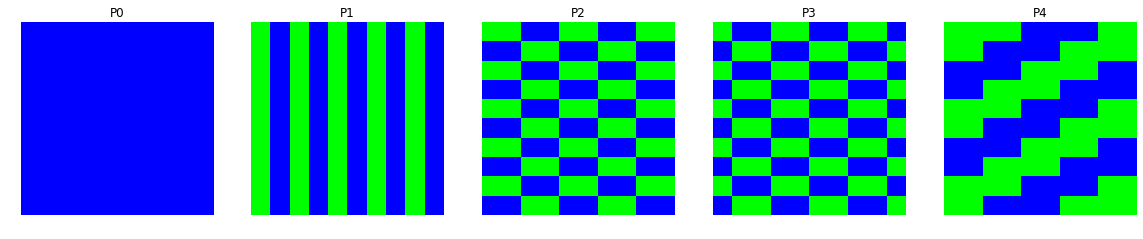

Stationary states


In [52]:
L = 10 # size of the newtork
N = L**2
K = 5 # number of stationary states of the system (memory patterns)
lamb = 0.4
eps = 1.0
T = 0.0 # Temperature
nsteps = 100 # number of steps of the simulation

iterate_plot(nsteps)